# Importing the data and necessary libraries

In [1]:
# Importing Necessary Datasets
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score as sklearn_precision_score, f1_score as sklearn_f1_score
from tabulate import tabulate
from sklearn.metrics import classification_report




df = pd.read_csv(r"D:\Accident Prediction\Publication 2023\Preparing the raw dataset\final_accident_data.csv")


# dropping the unnecessary columns as per feature selection
df.drop(columns=["Weather","Vehicle defects", "Road feature", "Alcohol", "Collision type", "Location type"], inplace=True)


df.head()

,Accident severity,Time,Junction type,Traffic control,Movement,Divider,Light,Road geometry,Surface condition,Surface type,Surface quality,Road class,Vehicle type,Vehicle maneuver,Vehicle loading,Seat belt
0,Non Fatal Injury,Night,Junction,control,1-way Street,Yes,No Daylight,Straight+Flat,Dry,Sealed,Good Quality,Regional,Others,Not Overtaking,Legal,No
1,Fatal Injury,Day,No Junction,control,2-way Street,Yes,No Daylight,Straight+Flat,Dry,Sealed,Good Quality,Regional,Others,Not Overtaking,Legal,No
2,Fatal Injury,Night,Junction,control,1-way Street,Yes,No Daylight,Straight+Flat,Dry,Sealed,Good Quality,Regional,Bus+Truck,Not Overtaking,Legal,No
3,Fatal Injury,Day,No Junction,control,2-way Street,Yes,No Daylight,Straight+Flat,Dry,Sealed,Good Quality,Regional,Others,Not Overtaking,Legal,Yes
4,Non Fatal Injury,Night,No Junction,control,1-way Street,Yes,No Daylight,Straight+Flat,Dry,Sealed,Good Quality,Regional,Bus+Truck,Not Overtaking,Legal,No


# Data Encoding

In [41]:
# Data Encoding

X = df.drop(columns="Accident severity") #Setting the independent variables
y = df["Accident severity"] # Setting the target Variable

# Spliting the datasets into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing Instances for One hot encoder for encoding caragorical datasets
encoder = OneHotEncoder(drop="first", sparse_output=False)
# Initializing the Label Encoder for encoding the target variable
le = LabelEncoder()

custom_encoding = ["Non Fatal Injury", "Fatal Injury"]

le.fit(custom_encoding)

le.classes_ = np.array(custom_encoding)

encoder.fit(X_train)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [42]:
unique_labels, counts = np.unique(y_train_encoded, return_counts = True)
print(unique_labels, counts)
le.classes_

[0 1] [251 944]


array(['Non Fatal Injury', 'Fatal Injury'], dtype='<U16')

# GridSearch For Hyperparameter Tuning

In [3]:
# Defining a dictionary to hold the classifier models and their respective parameter grids

classifiers = {
    'Decision Tree': (DecisionTreeClassifier(), {'criterion': ['gini', 'entropy'],
                                                 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8 ,9 ,10],
                                                 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10]}),
    'Random Forest': (RandomForestClassifier(), {'criterion': ['gini', 'entropy'],
                                                 'n_estimators': [100, 200, 300],
                                                 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                                                 'min_samples_split': [2, 3, 4, 5, 6, 7, 8 ,9 ,10],
                                                 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8 ,9 ,10]}),
    'Support Vector Machines': (SVC(), {'C': np.linspace(0.1, 10, 50),
                                        'gamma': ["scale", "auto"],
                                        'kernel': ['rbf', 'linear', 'poly']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 4, 5, 6, 7, 8 , 9, 10],
                                      'weights': ['uniform', 'distance'],
                                      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}),
    'Categorical Naive Bayes': (CategoricalNB(), {'alpha': [0.1, 0.5, 1.0],
                                                  'fit_prior': [True, False]}),
    'Logistic Regression': (LogisticRegression(), {'C': np.linspace(0.1, 10, 50),
                                                    'solver': ['liblinear', 'lbfgs'],
                                                    'max_iter': [400, 600, 800, 1000]}),
    'AdaBoost': (AdaBoostClassifier(), {'n_estimators': [50, 100, 150],
                                         'learning_rate': np.linspace(0.1, 1, 10)}),
    'XG Boost': (XGBClassifier(), {'learning_rate': np.linspace(0.1, 1, 10),
                                   'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                   'n_estimators': [50, 100, 150]})
}

# Defining a DataFrame to store the results
results_df = pd.DataFrame(columns=['Classifier', 'Best Parameters', 'Test Score'])

import random
random.seed(42)

# Iterating over the classifiers and perform grid search
for name, (classifier, param_grid) in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train_encoded, y_train_encoded)
    best_params = grid_search.best_params_
    classifier.set_params(**best_params)
    classifier.fit(X_train_encoded, y_train_encoded)
    y_pred = classifier.predict(X_test_encoded)
    test_score = accuracy_score(y_test_encoded, y_pred)
    new_row = pd.DataFrame({'Classifier': [name], 'Best Parameters': [best_params], 'Test Score': [test_score]})
    results_df = pd.concat([results_df, new_row], ignore_index=True)

# Printing the results in table format
pd.set_option("display.max_colwidth", None)

results_df


,Classifier,Best Parameters,Test Score
0,Decision Tree,"{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 2}",0.772575
1,Random Forest,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}",0.779264
2,Support Vector Machines,"{'C': 1.3122448979591839, 'gamma': 'scale', 'kernel': 'rbf'}",0.775920
3,KNN,"{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}",0.749164
4,Categorical Naive Bayes,"{'alpha': 0.5, 'fit_prior': True}",0.745819
5,Logistic Regression,"{'C': 0.1, 'max_iter': 400, 'solver': 'liblinear'}",0.775920
6,AdaBoost,"{'learning_rate': 0.1, 'n_estimators': 50}",0.785953
7,XG Boost,"{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}",0.755853


# All Classifier Model

In [43]:
# Defining a dictionary to hold the classifier models
classifiers = {
    'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf= 6, min_samples_split= 2, random_state=42),
    'Random Forest': RandomForestClassifier(criterion="gini", max_depth= 10, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 300, random_state=42),
    'Support Vector Machines': SVC(C= 1.312, gamma="scale", kernel="rbf", random_state=42),
    'KNN': KNeighborsClassifier(algorithm= 'auto', n_neighbors= 9, weights= 'uniform'),
    'Categorical Naive Bayes': CategoricalNB(alpha= 0.5, fit_prior= True),
    'Logistic Regression': LogisticRegression(C= 0.1, max_iter= 400, solver= "liblinear", random_state=42),
    'AdaBoost': AdaBoostClassifier(learning_rate= 0.1, n_estimators= 50, random_state=42),
    'XG Boost': XGBClassifier(learning_rate= 0.1, max_depth= 4, n_estimators= 50, random_state=42)
}

import pandas as pd

# Initializing an empty list to hold the scores
score_tables = []

# Iterating over the classifiers and calculate the scores
for name, classifier in classifiers.items():
    classifier.fit(X_train_encoded, y_train_encoded)
    y_pred = classifier.predict(X_test_encoded)
    test_score = accuracy_score(y_test_encoded, y_pred)
    precision = sklearn_precision_score(y_test_encoded, y_pred)
    f1 = sklearn_f1_score(y_test_encoded, y_pred)
    cm = confusion_matrix(y_test_encoded, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    fpr = FP / (FP + TN)
    rs = recall_score(y_test_encoded, y_pred)
    specificity = TN / (TN + FP)
    if hasattr(classifier, "predict_proba"):
        # Use predict_proba if available
        y_pred_prob = classifier.predict_proba(X_test_encoded)[:, 1]
        roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)
    
    # Creating a DataFrame for the current classifier's scores
    score_df = pd.DataFrame({
        "Classifier": [name],
        "Specificity" : [specificity],
        "Accuracy": [test_score],
        "Precision Socre" : [precision],
        "F1_score" : [f1],
        "Recall Score": [rs],
        "ROC AUC Score": [roc_auc]
    })
    
    # Appending the scores DataFrame to the list
    score_tables.append(score_df)

# Transforming the DataFrames into a single table
score_table = pd.concat(score_tables, ignore_index=True)

# Print the table
score_table


,Classifier,Specificity,Accuracy,Precision Socre,F1_score,Recall Score,ROC AUC Score
0,Decision Tree,0.095238,0.772575,0.797872,0.868726,0.953390,0.675242
1,Random Forest,0.063492,0.769231,0.792982,0.867562,0.957627,0.720339
2,Support Vector Machines,0.000000,0.775920,0.786441,0.873823,0.983051,0.720339
3,KNN,0.079365,0.749164,0.790614,0.853801,0.927966,0.706147
4,Categorical Naive Bayes,0.206349,0.745819,0.807692,0.846774,0.889831,0.669088
5,Logistic Regression,0.047619,0.775920,0.792388,0.872381,0.970339,0.669626
6,AdaBoost,0.063492,0.785953,0.796552,0.878327,0.978814,0.661051
7,XG Boost,0.111111,0.755853,0.796364,0.857143,0.927966,0.686777


# Plotting the AUC Curve

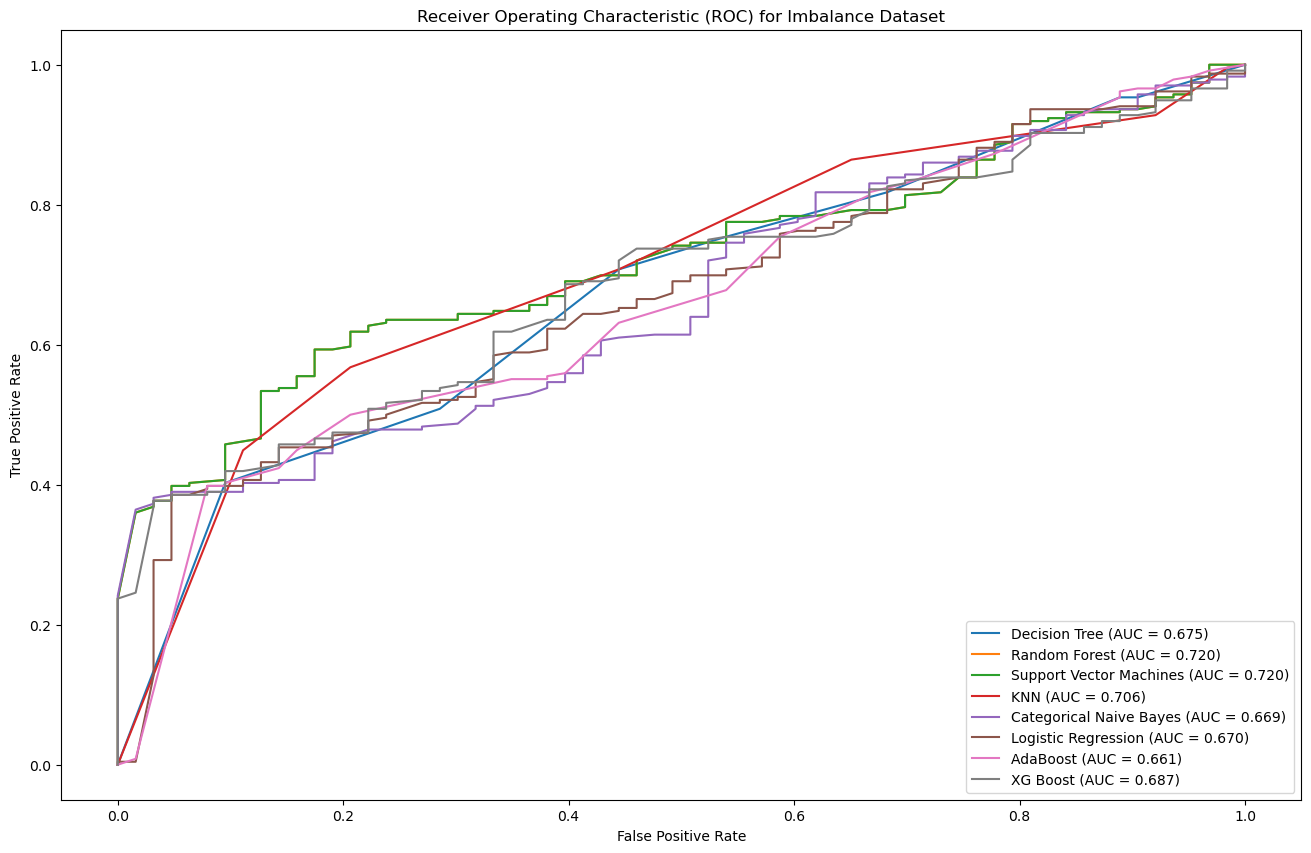

In [46]:
# Creating a figure and axes for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterating over the classifiers and ploting ROC curves
for name, classifier in classifiers.items():
    classifier.fit(X_train_encoded, y_train_encoded)
    
    if hasattr(classifier, "predict_proba"):
        
        y_pred_prob = classifier.predict_proba(X_test_encoded)[:, 1]
        
    fpr, tpr, thresholds = metrics.roc_curve(y_test_encoded, y_pred_prob)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

# Setting the labels and title for the plot
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) for Imbalance Dataset')

# Increasing the size of the plot
fig.set_size_inches(16, 10)

ax.legend(loc='lower right')

# Show the plot
plt.show()


In [45]:
results_df.to_csv(r"D:\Accident Prediction\Publication 2023\Hyper Parameters.csv", index=False)
score_table.to_csv(r"D:\Accident Prediction\Publication 2023\score_table.csv", index=False)